In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import dateutil.parser
import time
from pandas import DataFrame
import datetime

from scipy.special import gamma

import matplotlib.pyplot as plt

# Evaluación estadístico de salto
---
En este notebook evaluaremos el estadístico de salto definido en Dungey 2009 como:

$$JS_{t+1}(\delta)=\frac{RV_{t+1}(\delta)-BV_{t+1}(\delta)}{\sqrt{(\mu_1^{-4}+2\mu_1^{-2}-5) \max\{1, TQ_{t+1}(\delta)BV_{t+1}(\delta)^{-2}\}}}$$

Comenzamos definiendo una función que particiona los datos por días. Luego, iremos definiendo los parámetros de volatilidad realizada, bi-power variation y tri-power quarticity necesarios para evaluar el estadístico.

In [4]:
# Funcion que retorna una lista con entradas que corresponden a los datos de un dia para una accion

def sep_date(stockdata):
    #days = GetDate(stockdata)
    days = stockdata["dia"].drop_duplicates(keep="first").values
    daily_dfs = []
    for i in days:
        daily_dfs.append(stockdata.loc[stockdata["dia"] == i])
    return daily_dfs

La volatilidad realizada será: $$RV_{t+1}(\delta) = \sum_{j=1}^{1/\delta} r^2_{t+j\delta, \delta}$$
donde $$r_{t+j\delta, \delta} = p_{t+j\delta}-p_{t+(j-1)\delta}$$

In [5]:
# Realized volatility

def RV(stockdailyret):
    return np.sum(np.square(stockdailyret))

El bi-power variation es:

$$BV_{t+1}(\delta) = \mu_1^{-2} \sum_{j=2}^{1/\delta}|r_{t+j\delta, \delta}||r_{t+(j-1)\delta, \delta}|$$

In [18]:
# Bi-power variation

def BV(stockdailyret):
    
    mu1  = np.sqrt(2/np.pi)
    sums = 0
    for i in range(1,len(stockdailyret)):
        sums += np.abs(stockdailyret[i] * stockdailyret[i-1])
    
    #return (1/np.sqrt(mu1))*sums
    return (np.power(mu1, -2.))*sums

Finalmente, el tri-power quarticity es:

$$TQ_{t+1}(\delta)=(\delta)^{-1}\mu_{4/3}^{-3} \sum_{j=3}^{1/\Delta} |r_{t+j\delta, \delta}||r_{t+(j-1)\delta, \delta}||r_{t+(j-2)\delta, \delta}|$$

In [21]:
# Tri-power quarticity

def TQ(stockdailyret):
    
    delt = 25.
    mu43 = 1./(np.float_power(2., 0.66666666)*gamma(7./6.)*gamma(0.5))
    #print(mu43)
    sums = 0
    stockdailyret = np.abs(stockdailyret)
    pp = 4./3.
    
    for i in range(2, len(stockdailyret)):
        temp  = np.float_power(stockdailyret[i], pp) * np.float_power(stockdailyret[i-1], pp) * np.float_power(stockdailyret[i-2], pp)
        sums += temp
        
    return delt*(mu43**3)*sums

# Evaluación de las funciones
---
Comenzamos a evaluar los resultados. Primero, importamos los datos

In [13]:
# Traemos los datos

data = pd.read_csv("depth_data.csv")
data.head()

,date_time,nombre,date_time.1,tipo,precio,volumen,BID,ASK,Mid_Price,Quoted_Spread,dia,BID_depth,ASK_depth,Depth,log_depth
0,2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,ASK,1320.0,360000.0,NaN,NaN,NaN,NaN,2017-03-03,0.0,0.0,0.0,0.000000
1,2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,BID,1305.0,100000.0,1305.0,1320.0,1312.5,0.011429,2017-03-03,100000.0,360000.0,460000.0,24.306785
2,2017-03-03 09:30:02,ECOPETL CB Equity,2017-03-03 09:30:02,ASK,1315.0,80000.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,100000.0,80000.0,180000.0,22.802707
3,2017-03-03 09:30:03,ECOPETL CB Equity,2017-03-03 09:30:03,ASK,1315.0,155240.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,100000.0,235240.0,335240.0,23.881287
4,2017-03-03 09:30:12,ECOPETL CB Equity,2017-03-03 09:30:12,BID,1305.0,170000.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,270000.0,235240.0,505240.0,24.874539


Obtenemos una lista cuyas entradas contiene un dataframe con todos los datos para aquel día

In [43]:
day_data = sep_date(data)
day_data[0].head()

,date_time,nombre,date_time.1,tipo,precio,volumen,BID,ASK,Mid_Price,Quoted_Spread,dia,BID_depth,ASK_depth,Depth,log_depth
0,2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,ASK,1320.0,360000.0,NaN,NaN,NaN,NaN,2017-03-03,0.0,0.0,0.0,0.000000
1,2017-03-03 09:30:00,ECOPETL CB Equity,2017-03-03 09:30:00,BID,1305.0,100000.0,1305.0,1320.0,1312.5,0.011429,2017-03-03,100000.0,360000.0,460000.0,24.306785
2,2017-03-03 09:30:02,ECOPETL CB Equity,2017-03-03 09:30:02,ASK,1315.0,80000.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,100000.0,80000.0,180000.0,22.802707
3,2017-03-03 09:30:03,ECOPETL CB Equity,2017-03-03 09:30:03,ASK,1315.0,155240.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,100000.0,235240.0,335240.0,23.881287
4,2017-03-03 09:30:12,ECOPETL CB Equity,2017-03-03 09:30:12,BID,1305.0,170000.0,1305.0,1315.0,1310.0,0.007634,2017-03-03,270000.0,235240.0,505240.0,24.874539


Calculamos el retorno para cada día que esté en la fecha `day_data`

In [51]:
daily_return = [(i["precio"].diff()/i["precio"]).values for i in day_data]
daily_return[0]

array([        nan, -0.01149425,  0.00760456,  0.        , -0.00766284,
        0.00760456,  0.        , -0.00766284,  0.        ,  0.00760456,
       -0.00766284,  0.        ,  0.        ,  0.00760456, -0.00766284,
        0.        ,  0.        ,  0.        ,  0.00381679, -0.00383142,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00381679,  0.        , -0.00383142,  0.00381679,
        0.        ,  0.        ,  0.        , -0.00383142,  0.00381679,
        0.        ,  0.00380228, -0.00381679,  0.00380228, -0.00381679,
        0.00380228, -0.00381679,  0.        ,  0.        , -0.00383142,
        0.        ,  0.00760456, -0.00381679,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00380228,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00378788, -0.00380228, -0.00381679,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

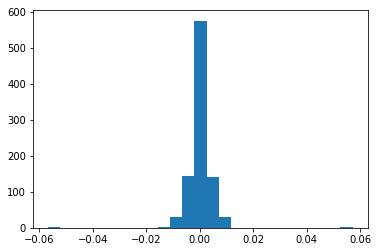

In [52]:
# Vemos como es la distribucion de los retornos para el primer dia

plt.hist(daily_return[0][1:], bins=25) # No tomamos el primer valor ya que es un NaN
plt.show()

In [22]:
np.shape(daily_return)

(119,)

In [23]:
RV(daily_return[0][1:])

0.014077347474951008

In [24]:
BV(daily_return[0][1:])

0.010837294308028305

In [39]:
TQ(daily_return[0][1:])

0.38310850596731383


4.791685824464193e-07

# Estadístico de salto
---
Ahora, aplicamos las funciones definidas previamente para el cálculo del estadístico de salto

In [31]:
# Jump statistic

def JS(stockdailyret):
    
    mu1  = np.sqrt(2/np.pi)
    #mu43 = 1./np.float_power(2., 0.66666666)*gamma(7./6.)*gamma(0.5)
    
    rv = RV(stockdailyret)
    bv = BV(stockdailyret)
    tq = TQ(stockdailyret)
    
    num = rv-bv
    den = np.sqrt((np.float_power(mu1, -4.) + 2*np.float_power(mu1, -2.) - 5) * max(1, np.float_power(tq*bv, -2)))
    print(num, "---", den)
    
    return num/den

In [33]:
JS(daily_return[0][1:])

0.0032400531669227028 --- 150278626.29446143


2.156030599171185e-11

Comenzamos el cálculo del estadístico de salto para los datos de ECOPETL

In [34]:
def total_JS(stockdata):
    
    days      = stockdata["dia"].drop_duplicates(keep="first").values
    daily_dat = sep_date(stockdata)
    daily_JS  = []
    
    for i in daily_dat:
        daily_ret = (i["precio"].diff()/i["precio"]).values[1:]
        # daily_ret[np.isnan(daily_ret)] = 0.0
        daily_JS.append(JS(daily_ret))
        
    JS_df = pd.DataFrame(daily_JS, index=days, columns=["Jump_statistic"])
        
    return JS_df

In [35]:
test_JS = total_JS(data)

0.0032400531669227028 --- 150278626.29446143
0.0026454313536767504 --- 5687564928.568631
0.001924688923488362 --- 594642728.4393307
0.002614410504591125 --- 12928173010.105246
0.01294877675778521 --- 59811938.42227262
0.0035408708645805163 --- 120997432.19068243
0.0018770694393750041 --- 16512538457.16421
0.0034825712045608234 --- 2057213628.408044
0.002695938779114218 --- 18581185191.405216
0.002744512493030412 --- 2782992184.533627
0.00190592546475049 --- 9604971922.424004
0.002464216586689659 --- 27175858839.89848
0.0031967948814838644 --- 1487153.5725438057
0.012642922932442294 --- 30666663.726933274
0.001748344440438814 --- 11820293363.625666
0.002059732502312716 --- 8640519090.004831
0.0035406742569652344 --- 3425607511.7855387
0.0028296785349555707 --- 2130813468.0203135
0.006786323435380644 --- 5099484402.852102
0.005637029716386674 --- 48355.5039852989
0.001671416594961581 --- 1182301970.4671555
0.006674492355744462 --- 25644726.653897706
0.003671752031694361 --- 5625802637.17

In [36]:
test_JS.head()

,Jump_statistic
2017-03-03,2.156031e-11
2017-03-06,4.651255e-13
2017-03-07,3.236715e-12
2017-03-08,2.022258e-13
2017-03-09,2.164915e-10


In [37]:
jump = test_JS.values > 1.96

In [38]:
jump

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [